In [61]:
pip install python-igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import igraph as ig
from igraph import *
import json
import random
import numpy as np
from numpy import linalg 
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay  # needed for triangulation
import os
import pandas as pd
from copy import deepcopy

In [88]:
random.seed(2022)
np.random.seed(2022)

In [89]:
with open('/content/los_angeles_censustracts.json') as f:
    census_tracts = json.loads(f.readline())

In [90]:
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [91]:
graph = Graph(directed=False)
graph.add_vertices(len(display_names))
graph.vs['display_name'] = list(display_names.values())  # index = id - 1
graph.vs['coordinates'] = list(coordinates.values())

In [92]:
datasets = pd.read_csv('los_angeles-censustracts-2020-1-All-MonthlyAggregate.csv', usecols=['sourceid', 'dstid', 'mean_travel_time', 'month'])
datasets = datasets[datasets['month'].isin([1, 2, 3])][['sourceid', 'dstid', 'mean_travel_time']]
# change start of movement id 1 -> 0
edges = datasets.sub([1, 1, 0])
edges.rename(columns = {'mean_travel_time':'time'}, inplace = True)

In [93]:
from collections import defaultdict
vtxDict = defaultdict(list)
with open('los_angeles_censustracts.json') as f:
    census_tracts = json.loads(f.readline())
    for area in census_tracts['features']:
        # change start of movement id 1 -> 0
        id = int(area['properties']['MOVEMENT_ID']) - 1
        display = area['properties']['DISPLAY_NAME']
        a = area['geometry']['coordinates'][0]
        # considering polygon & multipolygon area types
        centloc = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)
        vtxDict['id'].append(id)
        vtxDict['display'].append(display)
        vtxDict['centloc'].append(centloc)

vertices = pd.DataFrame(vtxDict)

In [94]:
graph = ig.Graph.DataFrame(edges, directed=False, vertices=vertices)
graphcomponent = graph.clusters().giant()
graphcomponent = graphcomponent.simplify(combine_edges=dict(time='mean'))
graphcomponent.es['distance'] = [np.linalg.norm(graphcomponent.vs[e.source]["centloc"] - graphcomponent.vs[e.target]["centloc"]) * 69
                      for e in graphcomponent.es]
graphcomponent.es['mark'] = [False] * len(graphcomponent.es)
print(len(graphcomponent.vs), len(graphcomponent.es))

<ipython-input-94-39b4851b431e>:2: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  gcc = g.clusters().giant()


In [95]:
minspantree = graphcomponent.spanning_tree(weights=graphcomponent.es['time'])

In [96]:
def preorderTraversal(graph, root): 
    stkforpop = []
    former =[] 
    former.append(root) 
    stkforpop.append(root) 
    while len(stkforpop)>0:
        flag = 0
        if graph.vs[stkforpop[-1]].degree(mode='OUT') == 0: 
            stkforpop.pop() 
        else: 
            par = stkforpop[-1]
        for cnkid in graph.vs[par].neighbors(mode='OUT'): 
            if cnkid.index not in former: 
                flag = 1
                stkforpop.append(cnkid.index) 
                former.append(cnkid.index) 
                break
        if flag == 0: 
            stkforpop.pop() 
    return former

In [97]:
def twoApprox(graph, root, weight): 
    pre = preorderTraversal(minspantree, root)
    pre.append(root)
    approximatecost = 0
    final_path = [root]
    for i in range(len(pre) - 1):
        eid = graph.get_eid(pre[i], pre[i+1], directed=False, error=False)
        if eid != -1:
            approximatecost += graph.es[eid]['time']
            final_path.append(pre[i+1])
        else:
            approximatecost += (graph.shortest_paths(pre[i], pre[i+1], weights=weight))[0][0]
            path = graph.get_shortest_paths(pre[i], pre[i+1], weights=weight, output='vpath')
            for ind in path[0][1:]:
                final_path.append(ind)
    return approximatecost, final_path

In [99]:
import sys
from tqdm import tqdm 
minspantree_cost = sum(minspantree.es['time'])
approximatecost_min = sys.maxsize
approximate_pth = []
pints = np.random.randint(1, high=len(graphcomponent.vs), size=30)
for point in tqdm(pints):
    cst_i, path = twoApprox(graphcomponent, point, 'time')
    if cst_i < approximatecost_min:
        approximatecost_min = cst_i
        approximate_pth = path


  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-97-3e8acc09d250>:12: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  cost_approx += (g.shortest_paths(pre[i], pre[i+1], weights=weight))[0][0]
100%|██████████| 30/30 [02:18<00:00,  4.62s/it]


In [100]:
x = [graphcomponent.vs[i]['centloc'][0] for i in approximate_pth]
y = [graphcomponent.vs[i]['centloc'][1] for i in approximate_pth]
bbox = (-118.75, -117.75, 33.7, 34.4)
la_map = plt.imread('la.png')

def plot_graph(g, title=''):
    plt.figure(dpi=150)
    
    for e in g.es:
        v1 = g.vs[e.source]['centloc']
        v2 = g.vs[e.target]['centloc']
        data = np.vstack([v1, v2])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y, c='orange' if e['mark'] else 'green', linewidth=1)

    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.imshow(la_map, zorder=0, extent=bbox, aspect='equal')
    plt.xlim(bbox[0], bbox[1])
    plt.ylim(bbox[2], bbox[3])
    plt.plot(x, y, marker='o', linewidth=1, markersize=2, markerfacecolor='red', color='green')

plot_graph(graphcomponent, 'The Updated Graph Component')
plt.show()


In [101]:

# Perform Delaunay triangulation on the graph component vertices
dlnayelau = Delaunay(graphcomponent.vs['centloc'])

edges_d = []

# Iterate over the simplices in the Delaunay triangulation
for i in range(dlnayelau.simplices.shape[0]):
    # Iterate over the edges of each simplex
    for a, b in ((0, 1), (1, 2), (0, 2)):
        # Check if the vertices of the edge are connected in the original graph
        if graphcomponent.are_connected(dlnayelau.simplices[i][a], dlnayelau.simplices[i][b]):
            # Add the connected edge to the list
            edges_d.append((dlnayelau.simplices[i][a], dlnayelau.simplices[i][b]))

# Create a subgraph with the edges obtained from Delaunay triangulation
g_d = graphcomponent.subgraph_edges(edges_d)


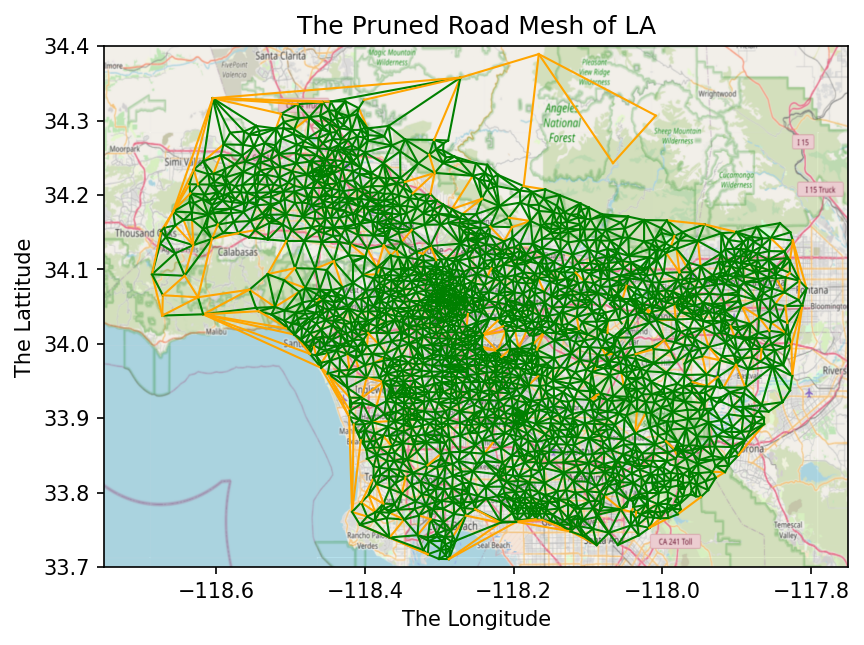

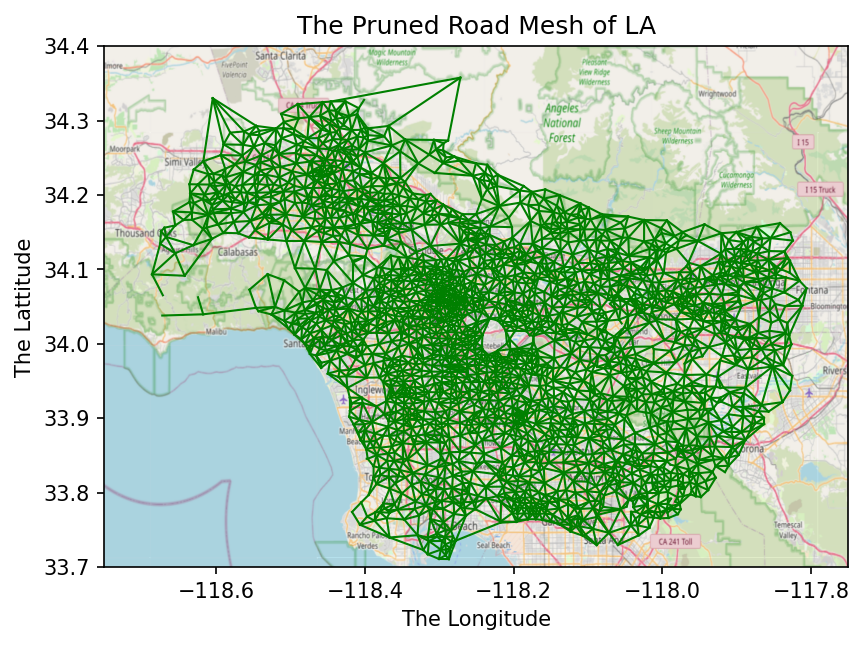

In [102]:
threshold_time = 420
edges_trim = g_d.es.select(time_le=threshold_time)

for e in g_d.es:
    if e not in edges_trim:
        e['mark'] = True

trimmedGraoh = g_d.subgraph_edges(edges_trim)

plot_graph(g_d, 'The Pruned Road Mesh of LA (Before Trimming)')
plt.show()

plot_graph(trimmedGraoh, 'The Pruned Road Mesh of LA (After Trimming)')
plt.show()


**10. Define Your Own Task**

In [103]:
tskgraph = deepcopy(trimmedGraoh)
gramusingwalktrap = ig.Graph.community_walktrap(tskgraph, weights='time')
vertex_cluster = gramusingwalktrap.as_clustering()
for i, c in enumerate(vertex_cluster):
  tskgraph.vs[c]['cluster'] = i
  es = tskgraph.es.select(_within=c)
  es['cluster'] = i

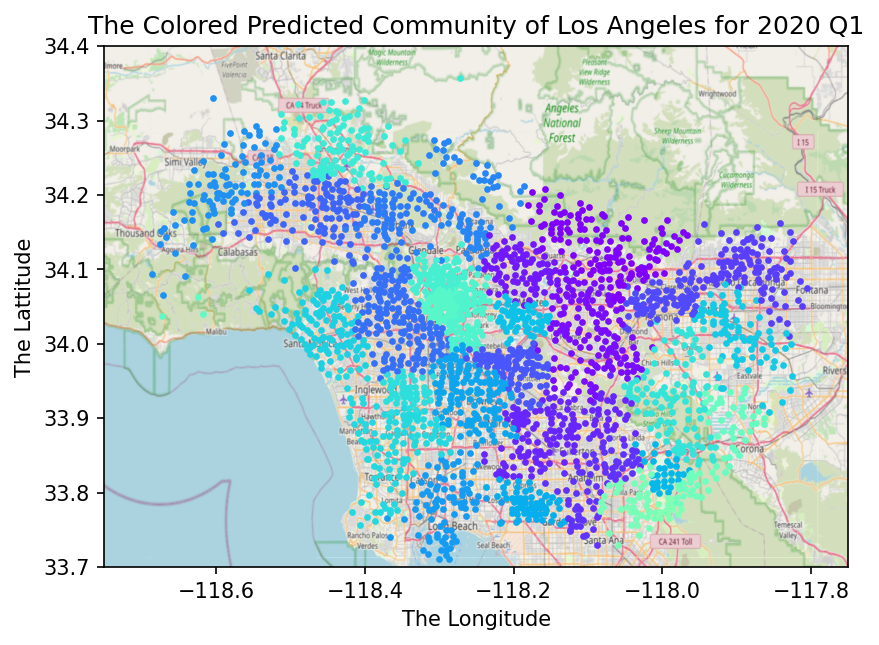

In [104]:
colors = plt.cm.rainbow(np.linspace(0, 0.5, len(vertex_cluster)))
plt.figure(dpi=150)
for v in tskgraph.vs:
    x = v['centloc'][0]
    y = v['centloc'][1]
    plt.scatter(x, y, color=colors[v['cluster']], s=5)

plt.title('The Colored Predicted Community of Los Angeles for 2020 Q1')
plt.xlabel('The Longitude')
plt.ylabel('The Latitude')
plt.imshow(la_map, zorder=0, extent=bbox, aspect='equal')
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.show()


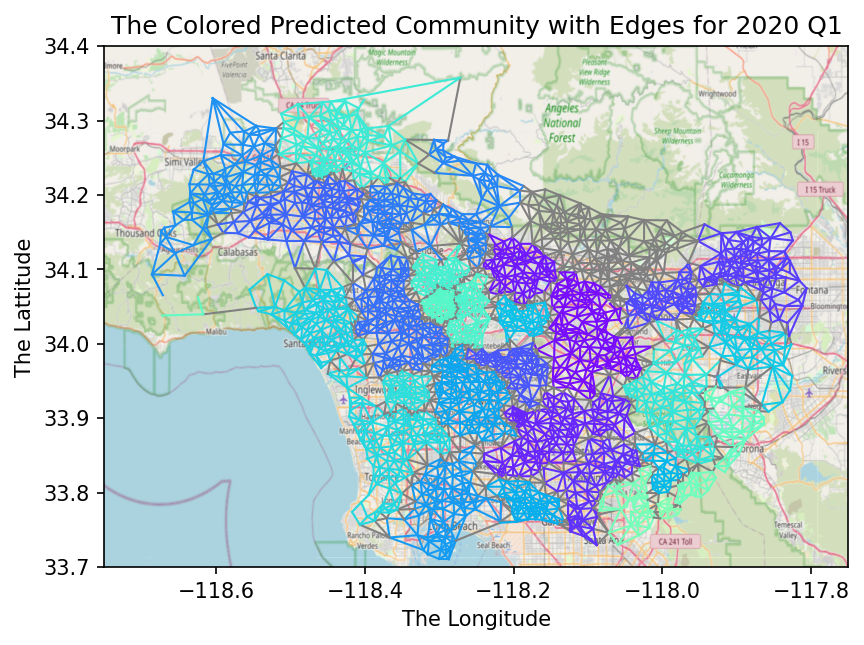

In [105]:
plt.figure(dpi=150)
for e in tskgraph.es:
    v1 = tskgraph.vs[e.source]['centloc']
    v2 = tskgraph.vs[e.target]['centloc']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y, color=colors[e['cluster']] if e['cluster'] else 'grey', linewidth=1)

plt.title('The Colored Predicted Community with Edges for 2020 Q1')
plt.xlabel('The Longitude')
plt.ylabel('The Latitude')
plt.imshow(la_map, zorder=0, extent=bbox, aspect='equal')
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.show()


In [115]:
def reduce(centlocs):
    return np.mean(centlocs, axis=0)

graph_clusert = vertex_cluster.cluster_graph(
    combined_vertices={
        'centloc': reduce,
        'cluster': 'first',
    },
    combine_edges={
        'time': 'mean',
        'capacity': 'sum',
    }
)

graph_clusert.es['distance'] = [np.linalg.norm(graph_clusert.vs[e.source]["centloc"] - graph_clusert.vs[e.target]["centloc"]) * 69 for e in graph_clusert.es]


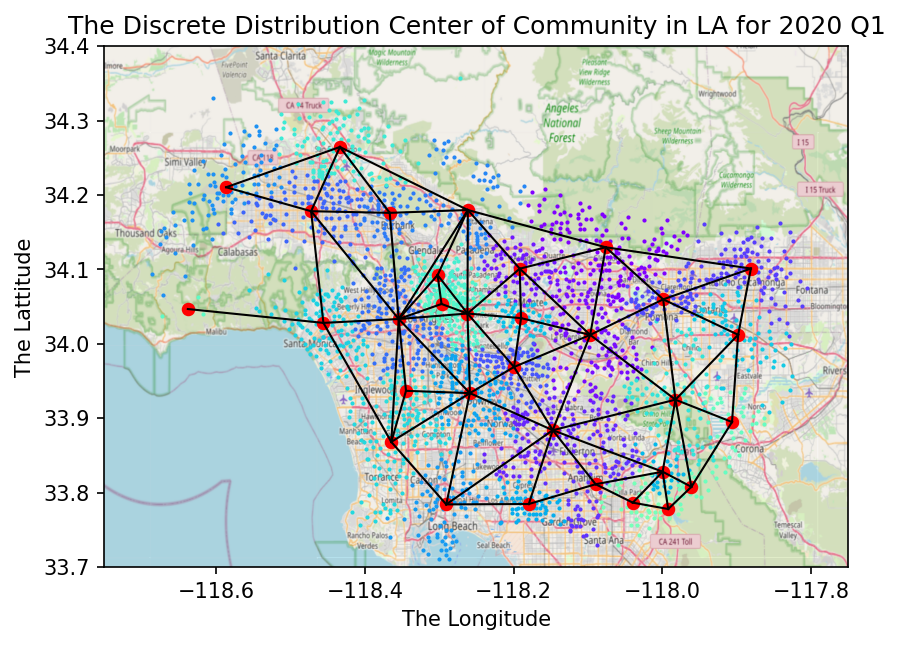

In [116]:
plt.figure(dpi=150)
for v in tskgraph.vs:
    x = v['centloc'][0]
    y = v['centloc'][1]
    plt.scatter(x, y, color=colors[v['cluster']], s=1)

for v in graph_clusert.vs:
    x = v['centloc'][0]
    y = v['centloc'][1]
    plt.scatter(x, y, color='red', s=30)

for e in graph_clusert.es:
    v1 = graph_clusert.vs[e.source]['centloc']
    v2 = graph_clusert.vs[e.target]['centloc']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y, color='black', linewidth=1)

plt.title('The Discrete Distribution Center of Community in LA for 2020 Q1')
plt.xlabel('The Longitude')
plt.ylabel('The Latitude')
plt.imshow(la_map, zorder=0, extent=bbox, aspect='equal')
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.show()


In [117]:

def TSP(g, s):
    vs = list(range(len(g.vs)))
    vs.remove(s)
    cost_min = sys.maxsize
    next_permutation = permutations(vs)
    
    for path in tqdm(next_permutation):
        cost_cur = 0
        i = s
        
        try:
            for j in path:
                cost_cur += g.es[g.get_eid(i, j)]['distance']
                i = j
            cost_cur += g.es[g.get_eid(i, s)]['distance']
        except:
            continue
        
        if cost_cur < cost_min:
            cost_min = cost_cur
            final_path = path

    return cost_min, final_path


In [118]:


minspantree = graph_clusert.spanning_tree(weights=graph_clusert.es['distance'])
minspantree_cost = sum(minspantree.es['distance'])
approximatecost_min = sys.maxsize
approximate_pth = []
pints = np.random.randint(1, high=len(graph_clusert.vs), size=10)
for point in tqdm(pints):
    cst_i, path = twoApprox(graphcomponent, point, 'distance')
    if cst_i < approximatecost_min:
        approximatecost_min = cst_i
        approximate_pth = path

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-97-3e8acc09d250>:12: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  cost_approx += (g.shortest_paths(pre[i], pre[i+1], weights=weight))[0][0]
100%|██████████| 10/10 [00:00<00:00, 971.47it/s]


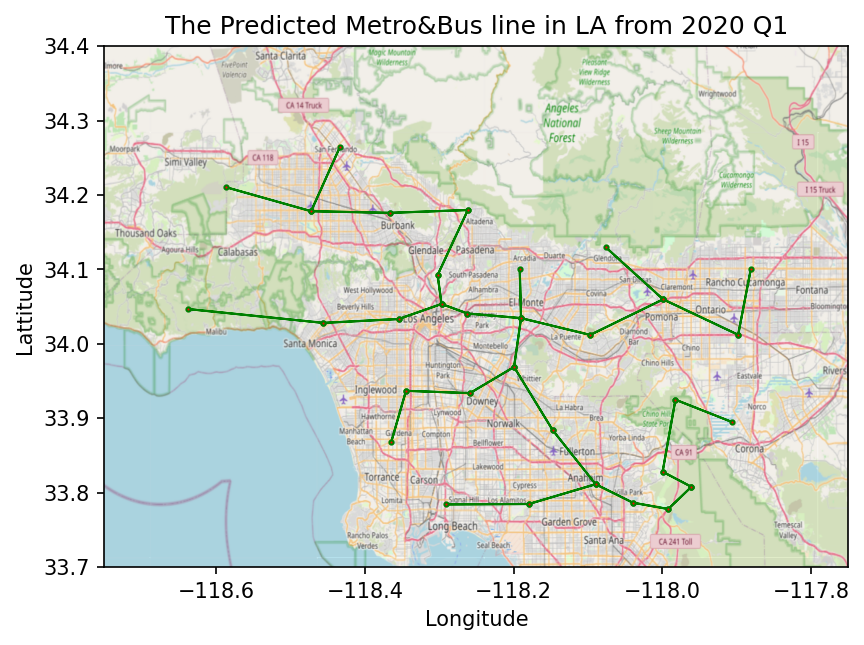

In [119]:
x = [graph_clusert.vs[i]['centloc'][0] for i in approximate_pth]
y = [graph_clusert.vs[i]['centloc'][1] for i in approximate_pth]
bbox = ((-118.75, -117.75, 33.7, 34.4))
la_map = plt.imread('la.png')

plt.figure(dpi=150)
plt.plot(x, y, marker='o', linewidth=1, markersize=2, markerfacecolor='red', color='green')
plt.title('The Predicted Metro&Bus line in LA from 2020 Q1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.imshow(la_map, zorder=0, extent=bbox, aspect='equal')
plt.show()
